## Predikcia vybranych parametrov
### Detached krivky

### Predikcia inclination, mass ratio, temperature ratio, potentials

In [1]:
# LIBRARIES
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler


In [2]:
from keras.utils import np_utils
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D
from keras.layers import Input, Dense, concatenate, Activation, LSTM, Dropout, Flatten
from keras.models import Model
from keras.layers.merge import Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
np.random.seed(1234)
pd.set_option('display.max_rows', None)

In [4]:
def generate_observation_sigma(space_obs_frac=0.5):
    """
    Draws a standard deviation of noise in light curve points from a "true" value provided in synthetic light curve.
    Noise sigma is drawn from bimodal distribution taking into account contributions from space based and earth based
    observations which have different levels of stochastic noise.

    :param space_obs_frac: ratio between earth based and space based observations
    :return: float; standard deviation of the light curve noise
    """
    earth_based_sigma = 4e-3
    space_based_sigma = 2e-4
    sigma = np.random.choice([earth_based_sigma, space_based_sigma], p=[1-space_obs_frac, space_obs_frac])
    return np.random.rayleigh(sigma)

def stochastic_noise_generator(curve):
    """
    Introduces gaussian noise into synthetic observation provided in `curve`.

    :param curve: numpy.array; normalized light curve
    :return: Tuple(numpy.array, float); normalized light curve with added noise, standard deviation of observations
    """
    sigma = generate_observation_sigma()
    return np.random.normal(curve, sigma), np.full(curve.shape, sigma)

## Data loading

In [5]:
data = pd.read_pickle("detached_all_parameters.pkl").reset_index()

In [6]:
data_sample = data.sample(n=150000)

In [7]:
list(data_sample.columns)

['index',
 'id',
 'curve',
 'primary__t_eff',
 'secondary__t_eff',
 'inclination',
 'mass_ratio',
 'primary__surface_potential',
 'secondary__surface_potential',
 't1_t2',
 'filter',
 'critical_surface_potential',
 'primary__equivalent_radius',
 'secondary__equivalent_radius',
 'primary__filling_factor',
 'secondary__filling_factor']

In [8]:
X = []
for row in data_sample["curve"]:
    X.append(row)
X=np.array(X)

In [9]:
y = np.array(data_sample[[
    "inclination",
    "mass_ratio",
    "primary__surface_potential",
    "secondary__surface_potential",
    "t1_t2"]])

In [10]:
# MinMax Scaler
scaler = MinMaxScaler()
y_minmax_scaled = scaler.fit_transform(y)
y_minmax_scaled[0]

array([0.71584635, 0.05050505, 0.17208073, 0.0020424 , 0.7804878 ])

In [11]:
X_train1, X_test, y_train1, y_test = train_test_split(X, y_minmax_scaled, test_size=0.2)

In [12]:
# Adding noise to train data
X_train_n = []
y_train_n = []
for i in range(len(X_train1)):
    for j in range(3):
        curve = stochastic_noise_generator(X_train1[i])
        X_train_n.append(curve[0])
        y_train_n.append(y_train1[i])
X_train_n = np.array(X_train_n)
y_train_n=np.array(y_train_n)

In [13]:
print("Number of records in dataset: ", len(data),
    "\nNumber of records in sample: ", len(X),
    "\nNumber of train data without noise: ", len(X_train1),
    "\nNumber of train data with noise: ", len(X_train_n),
    "\nNumber of test data without noise: ", len(X_test))

Number of records in dataset:  1300000 
Number of records in sample:  150000 
Number of train data without noise:  120000 
Number of train data with noise:  360000 
Number of test data without noise:  30000


## Model

In [17]:
inputs = Input(shape=(400, 1))
b = Conv1D(64, kernel_size = 3, padding = "valid")(inputs)
b = MaxPooling1D(2)(b)
b = Dropout(0.2)(b)
b = LSTM(64, return_sequences=True)(b)
b = Flatten()(b)
b = Dense(64, activation='relu')(b)
x = Dense(32, activation='relu')(b)
output = Dense(5, activation='linear')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae", "mape"])
print(model.summary())

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 400, 1)]          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 398, 64)           256       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 199, 64)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 199, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 199, 64)           33024     
_________________________________________________________________
flatten_1 (Flatten)          (None, 12736)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)               

In [ ]:
saved_model = "models/norm_detached_selection.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor = 'val_mae', verbose = 1, save_best_only = True, mode = 'min')
early = EarlyStopping(monitor = "val_mae", mode = "min", patience = 25)
callbacks_list = [checkpoint, early]

In [ ]:
history = model.fit(X_train_n, y_train_n, validation_split = 0.1, epochs = 10, verbose = 1, callbacks = callbacks_list, batch_size = 64)

In [ ]:
model = load_model("models/norm_detached_selection.hdf5")

## Model v2
Pridana konvolucna vrstva + zmenene pocty neuronov na konvolucnych vrstvach

In [20]:
inputs = Input(shape=(400, 1))
b = Conv1D(128, kernel_size = 3, padding = "valid")(inputs)
b = MaxPooling1D(2)(b)
b = Conv1D(64, kernel_size = 3, padding = "valid")(b)
b = Dropout(0.2)(b)
b = LSTM(64, return_sequences=True)(b)
b = Flatten()(b)
b = Dense(64, activation='relu')(b)
x = Dense(32, activation='relu')(b)
output = Dense(5, activation='linear')(x)
model_v2 = Model(inputs=inputs, outputs=output)
model_v2.compile(loss='mse', optimizer='adam', metrics=["mae", "mape"])
print(model_v2.summary())

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 400, 1)]          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 398, 128)          512       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 197, 64)           24640     
_________________________________________________________________
dropout_4 (Dropout)          (None, 197, 64)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 197, 64)           33024     
_________________________________________________________________
flatten_3 (Flatten)          (None, 12608)            

In [21]:
saved_model = "models/norm_detached_selection_v2.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor = 'val_mae', verbose = 1, save_best_only = True, mode = 'min')
early = EarlyStopping(monitor = "val_mae", mode = "min", patience = 25)
callbacks_list = [checkpoint, early]

In [22]:
history = model_v2.fit(X_train_n, y_train_n, validation_split = 0.1, epochs = 10, verbose = 1, callbacks = callbacks_list, batch_size = 64)

Epoch 1/10
5063/5063 [==============================] - ETA: 0s - loss: 0.0241 - mae: 0.0904 - mape: 1877585.0000
Epoch 00001: val_mae improved from inf to 0.08301, saving model to models\norm_detached_selection_v2.hdf5
5063/5063 [==============================] - 1039s 205ms/step - loss: 0.0241 - mae: 0.0904 - mape: 1877585.0000 - val_loss: 0.0224 - val_mae: 0.0830 - val_mape: 1993514.5000
Epoch 2/10
5063/5063 [==============================] - ETA: 0s - loss: 0.0161 - mae: 0.0690 - mape: 1673852.3750
Epoch 00002: val_mae improved from 0.08301 to 0.06328, saving model to models\norm_detached_selection_v2.hdf5
5063/5063 [==============================] - 1046s 207ms/step - loss: 0.0161 - mae: 0.0690 - mape: 1673852.3750 - val_loss: 0.0141 - val_mae: 0.0633 - val_mape: 1460208.1250
Epoch 3/10
5063/5063 [==============================] - ETA: 0s - loss: 0.0134 - mae: 0.0612 - mape: 1460427.5000
Epoch 00003: val_mae did not improve from 0.06328
5063/5063 [==============================] -

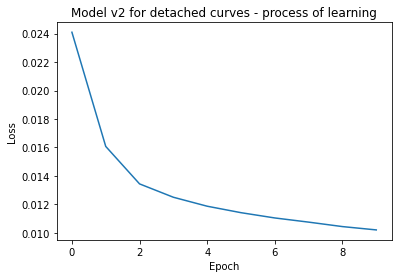

In [28]:
plt.plot(history.history['loss'])
plt.title("Model v2 for detached curves - process of learning")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("models_plots/model_v2.jpg")

## Model evaluation on  normalized test data

In [ ]:
# Normalized test data without noise
scores = model.evaluate(X_test, y_test)
print('Loss: {:.4f}, MAE: {:.4f}'.format(scores[0], scores[1]))

In [ ]:
# Adding noise to normalized test data
X_test_n = []
y_test_norm_n = []
for i in range(len(X_test)):
    for j in range(3):
        curve = stochastic_noise_generator(X_test[i])
        X_test_n.append(curve[0])
        y_test_norm_n.append(y_test[i])
        j += 1
X_test_n = np.array(X_test_n)
y_test_norm_n = np.array(y_test_norm_n)

In [ ]:
# Normalized test data with noise
scores_n = model.evaluate(X_test_n, y_test_norm_n)
print('Loss: {:.4f}, MAE: {:.4f}'.format(scores_n[0], scores_n[1]))

## Prediction on normalized test data without noise + inverse normalization

In [ ]:
y_pred_norm = model.predict(X_test)

In [ ]:
y_pred_norm[0]

In [ ]:
denorm = scaler.inverse_transform(y_pred_norm)
denorm[0]

In [ ]:
denorm_pred_df = pd.DataFrame(denorm,
                           columns = [
                                "inclination",
                                "mass_ratio",
                                "primary__surface_potential",
                                "secondary__surface_potential",
                                "t1_t2"
                            ])
denorm_pred_df.head()

In [ ]:
pred_mean = denorm_pred_df.mean(axis=0)
pred_mean

In [ ]:
y_test_df = pd.DataFrame(y,
                        columns = [
                            "inclination",
                            "mass_ratio",
                            "primary__surface_potential",
                            "secondary__surface_potential",
                            "t1_t2"
                            ])
test_mean = y_test_df.mean(axis=0)
test_mean

In [ ]:
eval_pred = pd.DataFrame({'attribute': test_mean.index,
            'avg_true': test_mean.values,
            'avg_pred': pred_mean.values,
            'MAE': abs(test_mean.values - pred_mean.values)})
eval_pred

## Prediction on normalized test data with noise + inverse normalization

In [ ]:
y_pred_norm_n = model.predict(X_test_n)

In [ ]:
denorm_n = scaler.inverse_transform(y_pred_norm_n)
denorm_n[0]

In [ ]:
denorm_pred_n_df = pd.DataFrame(denorm_n,
                            columns = [
                                "inclination",
                                "mass_ratio",
                                "primary__surface_potential",
                                "secondary__surface_potential",
                                "t1_t2"
                            ])
denorm_pred_n_df.head()

In [ ]:
pred_n_mean = denorm_pred_n_df.mean(axis=0)
pred_n_mean

In [ ]:
y_test_n_denorm = scaler.inverse_transform(y_test_norm_n)
y_test_norm_n_df = pd.DataFrame(y_test_n_denorm,
                            columns = [
                            "inclination",
                            "mass_ratio",
                            "primary__surface_potential",
                            "secondary__surface_potential",
                            "t1_t2"
                            ])
test_mean_n = y_test_norm_n_df.mean(axis=0)
test_mean_n

In [ ]:
eval_pred = pd.DataFrame({'attribute': test_mean_n.index,
            'avg_true': test_mean_n.values,
            'avg_pred': pred_n_mean.values,
            'MAE': abs(test_mean_n.values - pred_n_mean.values)})
eval_pred